In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import re

## Data Processing

In [2]:
full = pd.read_csv("Data/full_data.csv")
full.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,All_NBA_Pos,All_NBA_Team,All_NBA_Pts_Won,All_NBA_Pts_Max,All_NBA_Share,All_NBA_1st_Team_Votes,All_NBA_2nd_Team_Votes,All_NBA_3rd_Team_Votes,year,All_NBA_Boolean
0,Kareem Abdul-Jabbar*,C,41,LAL,74,1695,12.9,0.511,0.005,0.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
1,Mark Acres,C,26,BOS,62,632,8.2,0.507,0.009,0.421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
2,Michael Adams,PG,26,DEN,77,2787,17.5,0.567,0.431,0.363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
3,Mark Alarie,PF,25,WSB,74,1141,13.3,0.531,0.088,0.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False
4,Randy Allen,SG,24,SAC,7,43,6.9,0.428,0.053,0.105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-1989,False


We will need to remove the following columns because they are directly linked to the response variable.
- All_NBA_Pos: Position when considered for All NBA team. NA= no votes.
- All_NBA_Team: Which all-nba team the player was selected to (if any). ORV = player received votes for All-NBA team but did not make it. NA= no votes.
- All_NBA_Pts_Won: # of All-NBA points received. NA= no votes.
- All_NBA_Pts_Max: max number of All-NBA points possible for that year. Varies by year.NA= no votes.
- All_NBA_Share: share of All-NBA points won. All_NBA_Pts_Won/All_NBA_Pts_Max. This could be our response variable.
- All_NBA_1st_Team_Votes: # of 1st team votes
- All_NBA_2nd_Team_Votes: # of 2nd team votes
- All_NBA_3rd_Team_Votes: # of 3rd team votes

In [3]:
## Remove All ALL Stats except boolean All_Stars
remove_all_star = full.loc[:, ~full.columns.str.startswith('All_')]
remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]
remove_all_star.head()

/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_43699/1871535054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]


,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,player_id,year,All_NBA_Boolean
0,Kareem Abdul-Jabbar*,C,41,LAL,74,1695,12.9,0.511,0.005,0.250,...,2.0,2.9,0.082,-1.9,-0.2,-2.1,0.0,abdulka01,1988-1989,False
1,Mark Acres,C,26,BOS,62,632,8.2,0.507,0.009,0.421,...,0.5,0.9,0.066,-3.0,-0.4,-3.4,-0.2,acresma01,1988-1989,False
2,Michael Adams,PG,26,DEN,77,2787,17.5,0.567,0.431,0.363,...,2.9,8.3,0.143,2.7,0.2,2.9,3.4,adamsmi01,1988-1989,False
3,Mark Alarie,PF,25,WSB,74,1141,13.3,0.531,0.088,0.202,...,1.0,2.2,0.093,-1.1,-0.8,-2.0,0.0,alarima01,1988-1989,False
4,Randy Allen,SG,24,SAC,7,43,6.9,0.428,0.053,0.105,...,0.0,0.0,-0.035,-5.5,-1.7,-7.2,-0.1,allenra01,1988-1989,False


In [4]:
clean_df = remove_all_star.dropna()
clean_df

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,player_id,year,All_NBA_Boolean
0,Kareem Abdul-Jabbar*,C,41,LAL,74,1695,12.9,0.511,0.005,0.250,...,2.0,2.9,0.082,-1.9,-0.2,-2.1,0.0,abdulka01,1988-1989,False
1,Mark Acres,C,26,BOS,62,632,8.2,0.507,0.009,0.421,...,0.5,0.9,0.066,-3.0,-0.4,-3.4,-0.2,acresma01,1988-1989,False
2,Michael Adams,PG,26,DEN,77,2787,17.5,0.567,0.431,0.363,...,2.9,8.3,0.143,2.7,0.2,2.9,3.4,adamsmi01,1988-1989,False
3,Mark Alarie,PF,25,WSB,74,1141,13.3,0.531,0.088,0.202,...,1.0,2.2,0.093,-1.1,-0.8,-2.0,0.0,alarima01,1988-1989,False
4,Randy Allen,SG,24,SAC,7,43,6.9,0.428,0.053,0.105,...,0.0,0.0,-0.035,-5.5,-1.7,-7.2,-0.1,allenra01,1988-1989,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15438,Tremont Waters,PG,24,TOT,3,50,5.4,0.357,0.643,0.000,...,0.1,0.0,-0.042,-7.8,0.1,-7.7,-0.1,watertr01,2021-2022,False
15439,Derrick White,SG,27,TOT,75,2199,14.8,0.549,0.461,0.294,...,2.3,5.1,0.111,0.4,0.6,0.9,1.6,whitede01,2021-2022,False
15440,Justise Winslow,SF,25,TOT,48,774,13.1,0.479,0.257,0.257,...,1.1,0.8,0.048,-2.7,1.0,-1.7,0.1,winslju01,2021-2022,False
15441,Moses Wright,PF,23,TOT,4,14,18.3,0.470,0.250,0.750,...,0.0,0.1,0.180,1.1,0.4,1.4,0.0,wrighmo01,2021-2022,False


Data Distribution by season 

In [5]:
clean_df.groupby(['year'])['All_NBA_Boolean'].count()

year
1988-1989    352
1989-1990    380
1990-1991    386
1991-1992    381
1992-1993    390
1993-1994    402
1994-1995    406
1995-1996    427
1996-1997    440
1997-1998    437
1998-1999    437
1999-2000    438
2000-2001    439
2001-2002    439
2002-2003    427
2003-2004    440
2004-2005    463
2005-2006    455
2006-2007    458
2007-2008    451
2008-2009    445
2009-2010    440
2010-2011    449
2011-2012    478
2012-2013    467
2013-2014    480
2014-2015    490
2015-2016    475
2016-2017    485
2017-2018    537
2018-2019    526
2019-2020    527
2020-2021    539
2021-2022    596
Name: All_NBA_Boolean, dtype: int64

We will also need to subset the numeric columns.

In [6]:
numeric_col = pd.DataFrame(clean_df.dtypes[:-1]).reset_index()
numeric_col = numeric_col[numeric_col[0] != 'object']
numeric_col.columns = ['name', 'type']
numeric_col = list(numeric_col.name)
numeric_col

['Age',
 'G',
 'MP',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP']

#### Non Hierarchical Modeling

In [7]:
with pm.Model() as non_hierarchical_model:
    a = pm.Normal("a", mu=0, sigma=10)

    nba_est = a
    for i,col in enumerate(numeric_col):
        b = pm.Normal("b{}".format(i), mu=0, sigma=10)
        # Continous update of nba_est formula
        nba_est = nba_est + b * clean_df[col].values
    
    # Data likelihood
    nba_like = pm.Bernoulli(
        "nba_like",
        logit_p = nba_est,
        observed = clean_df.All_NBA_Boolean.astype(int).values
    )

In [8]:
with non_hierarchical_model:
    non_hierarchical_trace_model = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b22, b21, b20, b19, b18, b17, b16, b15, b14, b13, b12, b11, b10, b9, b8, b7, b6, b5, b4, b3, b2, b1, b0, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8126 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_43699/1454621896.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.plots.traceplot(non_hierarchical_trace_model)
/usr/local/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'b2'}>,
        <AxesSubplot:title={'center':'b2'}>],
       [<AxesSubplot:title={'center':'b3'}>,
        <AxesSubplot:title={'center':'b3'}>],
       [<AxesSubplot:title={'center':'b4'}>,
        <AxesSubplot:title={'center':'b4'}>],
       [<AxesSubplot:title={'center':'b5'}>,
        <AxesSubplot:title={'center':'b5'}>],
       [<AxesSubplot:title={'center':'b6'}>,
        <AxesSubplot:title={'center':'b6'}>],
       [<AxesSubplot:title={'center':'b7'}>,
        <AxesSubplot:title={'center':'b7'}>],
       [<AxesSubplot:title={'center':'b8'}>,
        <AxesSubplot:title={'center':'b8'}>],
       [<AxesSubplot:title={'center':'b9'}>,
        <AxesSubplot:title={'center':'b9'}>],
 

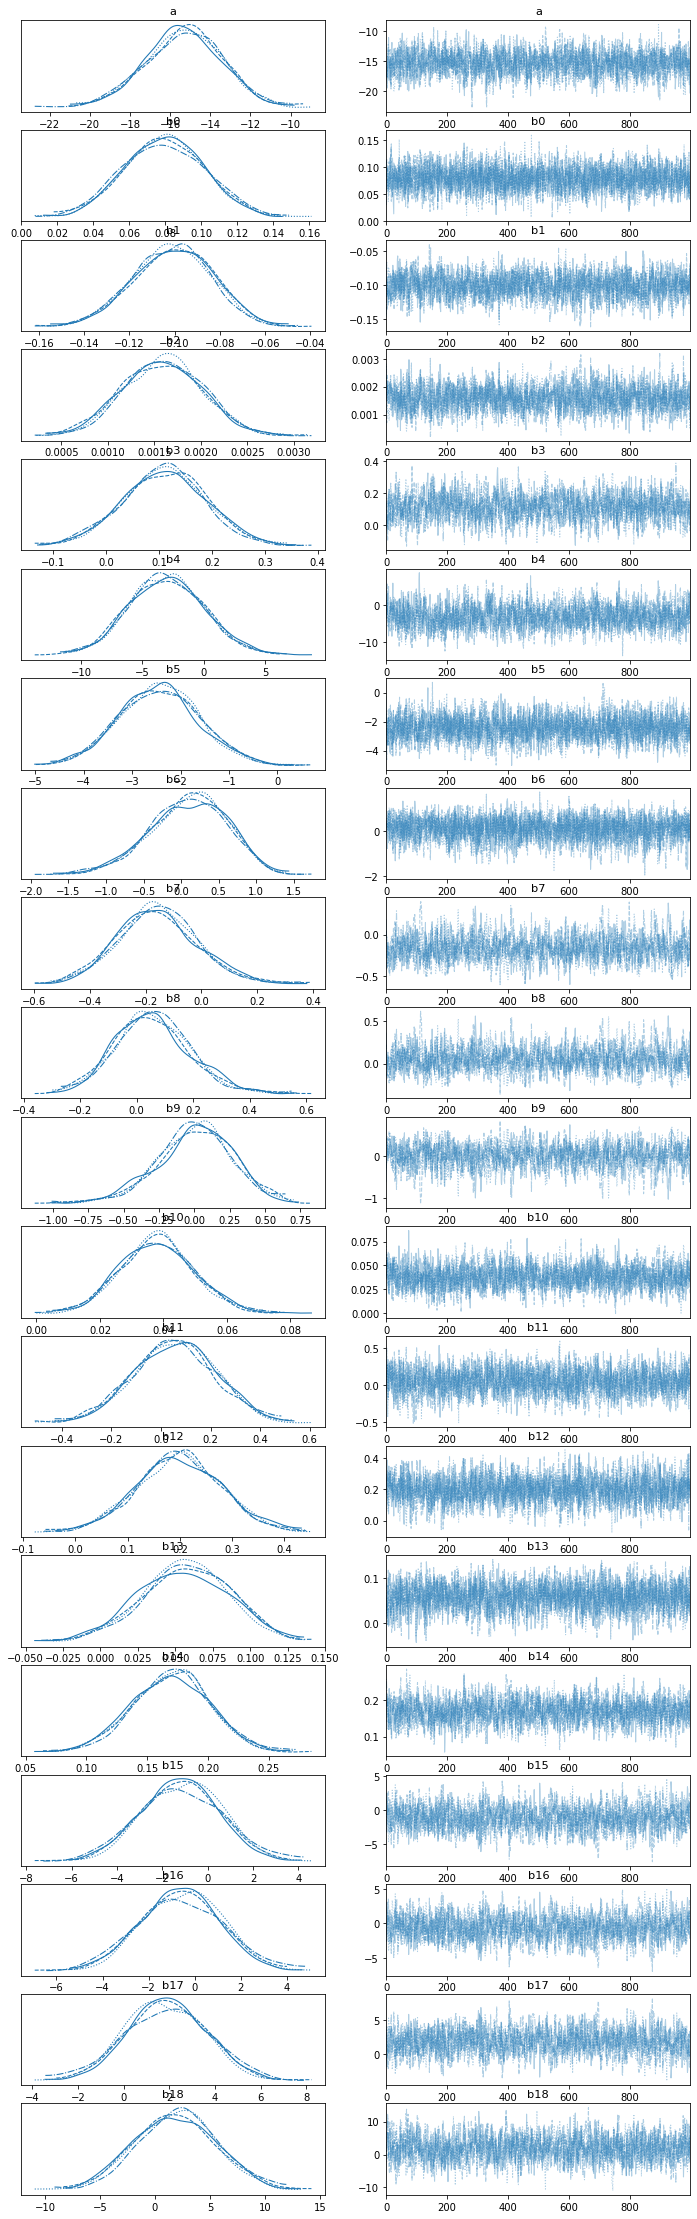

In [9]:
pm.plots.traceplot(non_hierarchical_trace_model)

In [10]:
pm.summary(non_hierarchical_trace_model).reset_index().rename(columns={"index":"distribution"})

,distribution,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,a,-15.320,1.906,-19.066,-11.861,0.050,0.036,1449.0,2245.0,1.00
1,b0,0.079,0.022,0.040,0.122,0.000,0.000,2806.0,2895.0,1.00
2,b1,-0.101,0.017,-0.134,-0.070,0.000,0.000,1610.0,2272.0,1.00
3,b2,0.002,0.000,0.001,0.002,0.000,0.000,1592.0,2277.0,1.00
4,b3,0.110,0.078,-0.047,0.250,0.002,0.002,1140.0,1865.0,1.00
5,b4,-3.012,3.076,-8.485,3.208,0.086,0.061,1282.0,1712.0,1.00
6,b5,-2.437,0.814,-3.895,-0.828,0.017,0.012,2249.0,2845.0,1.00
7,b6,0.096,0.516,-0.874,1.017,0.010,0.008,2760.0,2335.0,1.00
8,b7,-0.155,0.147,-0.436,0.125,0.005,0.004,882.0,1179.0,1.00
9,b8,0.057,0.136,-0.214,0.300,0.005,0.003,865.0,1200.0,1.00


In [11]:
beta_hashmap = {'a':'Intercept'}
# for i,col in enumerate(numeric_col.name):
for i,col in enumerate(numeric_col):
    beta = "b"+str(i)
    beta_hashmap[beta] = col
beta_hashmap

{'a': 'Intercept',
 'b0': 'Age',
 'b1': 'G',
 'b2': 'MP',
 'b3': 'PER',
 'b4': 'TS%',
 'b5': '3PAr',
 'b6': 'FTr',
 'b7': 'ORB%',
 'b8': 'DRB%',
 'b9': 'TRB%',
 'b10': 'AST%',
 'b11': 'STL%',
 'b12': 'BLK%',
 'b13': 'TOV%',
 'b14': 'USG%',
 'b15': 'OWS',
 'b16': 'DWS',
 'b17': 'WS',
 'b18': 'WS/48',
 'b19': 'OBPM',
 'b20': 'DBPM',
 'b21': 'BPM',
 'b22': 'VORP'}

In [12]:
beta_non_hierarchical = pm.summary(non_hierarchical_trace_model).reset_index().rename(columns={"index":"distribution"})
beta_non_hierarchical.distribution = beta_non_hierarchical.distribution.map(beta_hashmap)
beta_non_hierarchical

,distribution,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,Intercept,-15.320,1.906,-19.066,-11.861,0.050,0.036,1449.0,2245.0,1.00
1,Age,0.079,0.022,0.040,0.122,0.000,0.000,2806.0,2895.0,1.00
2,G,-0.101,0.017,-0.134,-0.070,0.000,0.000,1610.0,2272.0,1.00
3,MP,0.002,0.000,0.001,0.002,0.000,0.000,1592.0,2277.0,1.00
4,PER,0.110,0.078,-0.047,0.250,0.002,0.002,1140.0,1865.0,1.00
5,TS%,-3.012,3.076,-8.485,3.208,0.086,0.061,1282.0,1712.0,1.00
6,3PAr,-2.437,0.814,-3.895,-0.828,0.017,0.012,2249.0,2845.0,1.00
7,FTr,0.096,0.516,-0.874,1.017,0.010,0.008,2760.0,2335.0,1.00
8,ORB%,-0.155,0.147,-0.436,0.125,0.005,0.004,882.0,1179.0,1.00
9,DRB%,0.057,0.136,-0.214,0.300,0.005,0.003,865.0,1200.0,1.00
